# Feature-based mitotic classifier using gradient boosted decision trees

In [1]:
import os, sys, gc, itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm, tqdm_notebook

from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.core.display import display

## Plotting and analysis functions

In [2]:
def modelAnalysis(test_y, predict):
    target_na = ["not mitotic", "M1: prophase 1", "M2: prophase 2", "M3: pro metaphase 1", 
                 "M4: pro metaphase 2", "M5: metaphase", "M6: anaphase", "M7: telophase-cytokinesis"]
        
    print(classification_report(test_y, predict, target_names=target_na))
    print('accuracy', accuracy_score(test_y, predict))
    mat = confusion_matrix(test_y, predict)
    
    target_na = np.array(target_na)
    plt.figure(figsize=(10,10))
    a = plot_confusion_matrix(mat, classes = target_na, normalize = False)
    plt.grid(b=False)
    plt.show()

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    temp = []
    mat = cm
    for i in range(len(mat)):
        temp.append((mat[i, :].astype(np.float64)/(sum(mat[i])+1e-32).tolist()))
    
    mat = np.array(temp)
    
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = sum(cm[i])/ 2.
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def make_X_y_from_df(dataframe, X_cols, y_col,
                     make_y_int=True, drop_bad_vals=True):
    
    dataframe = dataframe[[y_col, *X_cols]]
    
    if drop_bad_vals:
        dataframe = dataframe.dropna()
        dataframe = dataframe[dataframe[target_col] >= 0]

    y = dataframe[y_col]
    X = dataframe[X_cols].values
    
    if make_y_int:
        le = LabelEncoder()
        le.fit(y)
        y = le.transform(y)
    else:
        y = y.values
        
    return X,y

## use ZY's feats

### Load data

In [5]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df = df.dropna(subset=['MitosisLabel'])

print('Release', df.query('MitoticHandoff == "Release"').shape)
print('Ongoing', df.query('MitoticHandoff == "Ongoing"').shape)
print('Pipeline', df.query('MitoticHandoff == "Pipeline"').shape)

df_release = df.query('MitoticHandoff == "Release"')
df_ongoing = df.query('MitoticHandoff == "Ongoing" | MitoticHandoff == "Pipeline"')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Release (4457, 2531)
Ongoing (2349, 2531)
Pipeline (786, 2531)


In [6]:
target_col = 'MitosisLabel'
feature_cols = ['feat_nuc_region_std_px',
                'feat_nuc_mt_edge_3',
                'feat_nuc_mt_edge_8',
                'feat_nuc_mt_edge_9',
                'feat_nuc_mt_edge_10',
                'feat_nuc_mt_edge_15',
                'feat_cell_obj_mean_depth',
                'feat_nuc_obj_tot_sphericity',
                'feat_nuc_obj_max_spherical_obj',
                'feat_nuc_obj_mean_spherical_obj']

### Train and test set -- use to find a good model

In [7]:
X_train_test, y_train_test = make_X_y_from_df(df_release,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_train_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([4207,   31,   22,   16,   39,   23,   27,   92]))

### Validation set -- held out until after model is locked down

In [8]:
X_validation, y_validation = make_X_y_from_df(df_ongoing,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_validation, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2787,   15,    8,   30,   59,   30,   44,  162]))

### Split train and test apart

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test,
                                                    test_size=0.2,
                                                    random_state=42)

unique_classes, class_counts = np.unique(y_train_test, return_counts=True)
class_weights = class_counts/np.sum(class_counts)
class_weights

lgb_train = lgb.Dataset(X_train, y_train,
                        weight=np.array([class_weights[int(i)] for i in y_train]),
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                        weight=np.array([class_weights[int(i)] for i in y_test]),
                       free_raw_data=False)

### Train the model

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(unique_classes),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 100
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_test,
                num_boost_round=1000,
                verbose_eval=100,
                early_stopping_rounds=5)

Training until validation scores don't improve for 5 rounds.
[100]	valid_0's multi_logloss: 0.571185
[200]	valid_0's multi_logloss: 0.202419
[300]	valid_0's multi_logloss: 0.0745731
[400]	valid_0's multi_logloss: 0.0282973
[500]	valid_0's multi_logloss: 0.0113013
[600]	valid_0's multi_logloss: 0.00503015
[700]	valid_0's multi_logloss: 0.00262506
[800]	valid_0's multi_logloss: 0.00165933
[900]	valid_0's multi_logloss: 0.00128055
[1000]	valid_0's multi_logloss: 0.00113574


### Training performance on  old data

                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      1.00      3371
           M1: prophase 1       1.00      0.38      0.56        26
           M2: prophase 2       0.95      0.90      0.92        20
      M3: pro metaphase 1       1.00      0.80      0.89        10
      M4: pro metaphase 2       0.91      1.00      0.96        32
            M5: metaphase       1.00      0.82      0.90        17
             M6: anaphase       0.94      0.74      0.83        23
M7: telophase-cytokinesis       0.91      0.95      0.93        66

              avg / total       0.99      0.99      0.99      3565

accuracy 0.991023842917


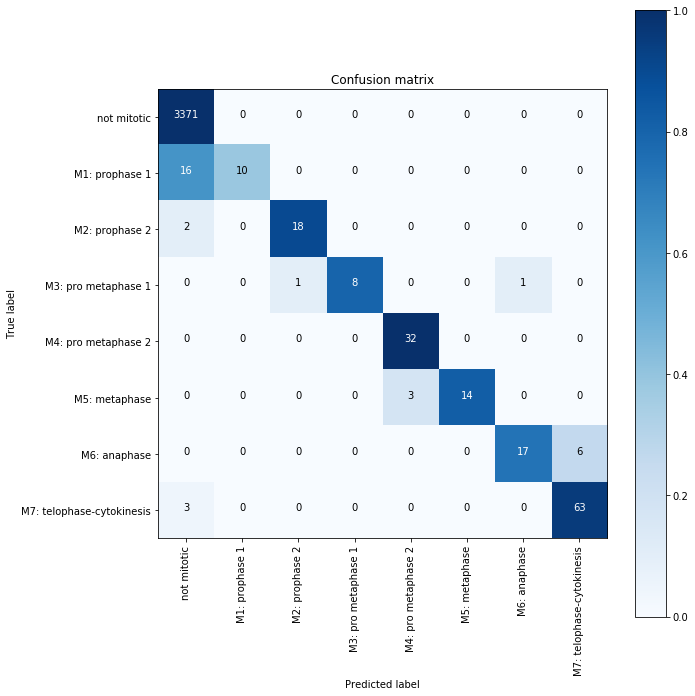

In [11]:
pred_classes_train = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_train)])
modelAnalysis(y_train, pred_classes_train)

### Testing performance on old data

                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      0.99       836
           M1: prophase 1       0.00      0.00      0.00         5
           M2: prophase 2       1.00      0.50      0.67         2
      M3: pro metaphase 1       1.00      0.17      0.29         6
      M4: pro metaphase 2       0.64      1.00      0.78         7
            M5: metaphase       1.00      0.50      0.67         6
             M6: anaphase       0.80      1.00      0.89         4
M7: telophase-cytokinesis       0.88      0.81      0.84        26

              avg / total       0.98      0.98      0.97       892

accuracy 0.97869955157


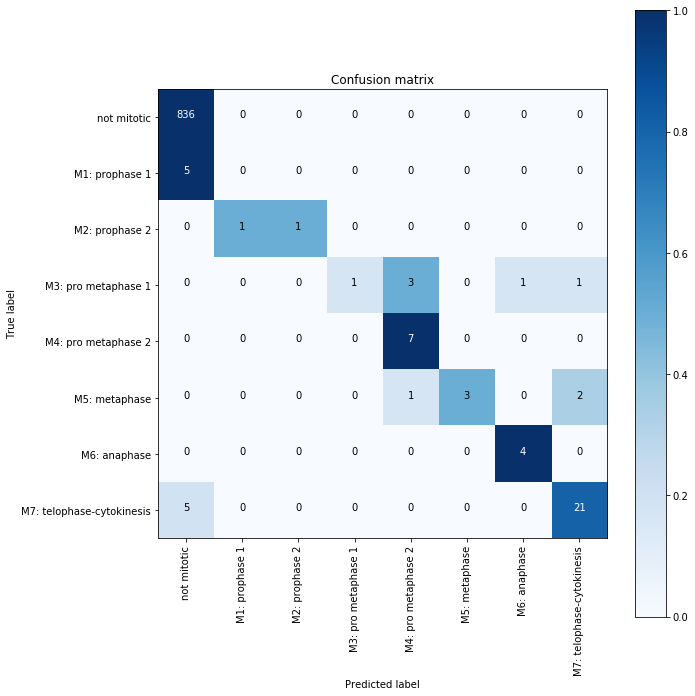

In [12]:
pred_classes_test = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_test)])
modelAnalysis(y_test, pred_classes_test)

## Use all features

### Load data

In [13]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df = df.dropna(subset=['MitosisLabel'])

print('Release', df.query('MitoticHandoff == "Release"').shape)
print('Ongoing', df.query('MitoticHandoff == "Ongoing"').shape)
print('Pipeline', df.query('MitoticHandoff == "Pipeline"').shape)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Release (4457, 2531)
Ongoing (2349, 2531)
Pipeline (786, 2531)


In [14]:
target_col = 'MitosisLabel'
feature_cols = df.columns[df.columns.str.contains(pat = 'feat_cell|feat_nuc')]

df = df.fillna(0)
df = df[df[target_col] >= 0]
df_release = df.query('MitoticHandoff == "Release"')
df_ongoing = df.query('MitoticHandoff == "Ongoing" | MitoticHandoff == "Pipeline"')

### Train and test set -- use to find a good model

In [15]:
X_train_test, y_train_test = make_X_y_from_df(df_release,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_train_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([4207,   31,   22,   16,   39,   23,   27,   92]))

In [16]:
X_train_test.shape

(4457, 1663)

### Validation set -- held out until after model is locked down

In [17]:
X_validation, y_validation = make_X_y_from_df(df_ongoing,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_validation, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2787,   15,    8,   30,   59,   30,   44,  162]))

### Split train and test apart

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test,
                                                    test_size=0.2,
                                                    random_state=42)

unique_classes, class_counts = np.unique(y_train_test, return_counts=True)
class_weights = class_counts/np.sum(class_counts)
class_weights

lgb_train = lgb.Dataset(X_train, y_train,
                        weight=np.array([class_weights[int(i)] for i in y_train]),
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                        weight=np.array([class_weights[int(i)] for i in y_test]),
                       free_raw_data=False)

### Train the model

In [19]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(unique_classes),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 100
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_test,
                num_boost_round=1000,
                verbose_eval=100,
                early_stopping_rounds=5)

Training until validation scores don't improve for 5 rounds.
[100]	valid_0's multi_logloss: 0.571236
[200]	valid_0's multi_logloss: 0.202842
[300]	valid_0's multi_logloss: 0.0748947
[400]	valid_0's multi_logloss: 0.0283659
[500]	valid_0's multi_logloss: 0.0112557
[600]	valid_0's multi_logloss: 0.00491042
[700]	valid_0's multi_logloss: 0.00251246
[800]	valid_0's multi_logloss: 0.001619
[900]	valid_0's multi_logloss: 0.00128379
[1000]	valid_0's multi_logloss: 0.00116913


### Training performance on  old data

                           precision    recall  f1-score   support

              not mitotic       1.00      1.00      1.00      3371
           M1: prophase 1       1.00      0.96      0.98        26
           M2: prophase 2       1.00      1.00      1.00        20
      M3: pro metaphase 1       1.00      1.00      1.00        10
      M4: pro metaphase 2       1.00      1.00      1.00        32
            M5: metaphase       1.00      1.00      1.00        17
             M6: anaphase       1.00      1.00      1.00        23
M7: telophase-cytokinesis       1.00      1.00      1.00        66

              avg / total       1.00      1.00      1.00      3565

accuracy 0.999719495091


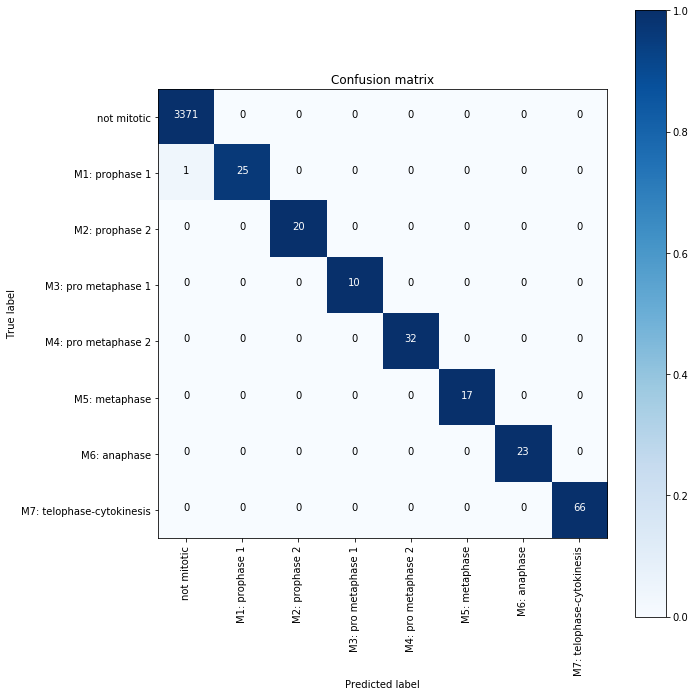

In [20]:
pred_classes_train = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_train)])
modelAnalysis(y_train, pred_classes_train)

### Testing performance on  old data

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      0.99       836
           M1: prophase 1       1.00      0.20      0.33         5
           M2: prophase 2       0.00      0.00      0.00         2
      M3: pro metaphase 1       0.50      0.17      0.25         6
      M4: pro metaphase 2       0.47      1.00      0.64         7
            M5: metaphase       0.00      0.00      0.00         6
             M6: anaphase       0.80      1.00      0.89         4
M7: telophase-cytokinesis       0.87      0.77      0.82        26

              avg / total       0.97      0.97      0.97       892

accuracy 0.974215246637


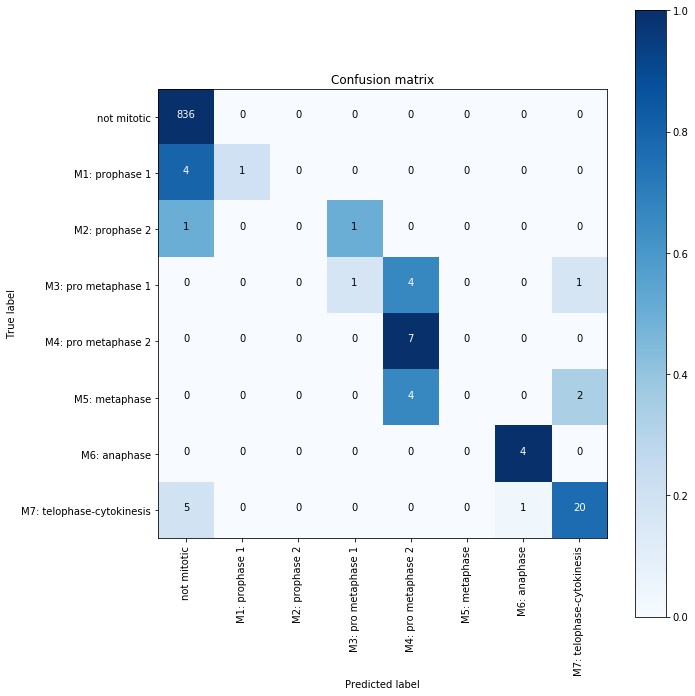

In [21]:
pred_classes_test = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_test)])
modelAnalysis(y_test, pred_classes_test)

### Validation performance on new held-out data

                           precision    recall  f1-score   support

              not mitotic       0.97      1.00      0.99      2787
           M1: prophase 1       0.50      0.07      0.12        15
           M2: prophase 2       0.83      0.62      0.71         8
      M3: pro metaphase 1       0.83      0.17      0.28        30
      M4: pro metaphase 2       0.56      0.68      0.61        59
            M5: metaphase       0.53      0.33      0.41        30
             M6: anaphase       0.50      0.18      0.27        44
M7: telophase-cytokinesis       0.71      0.65      0.68       162

              avg / total       0.94      0.94      0.94      3135

accuracy 0.944497607656


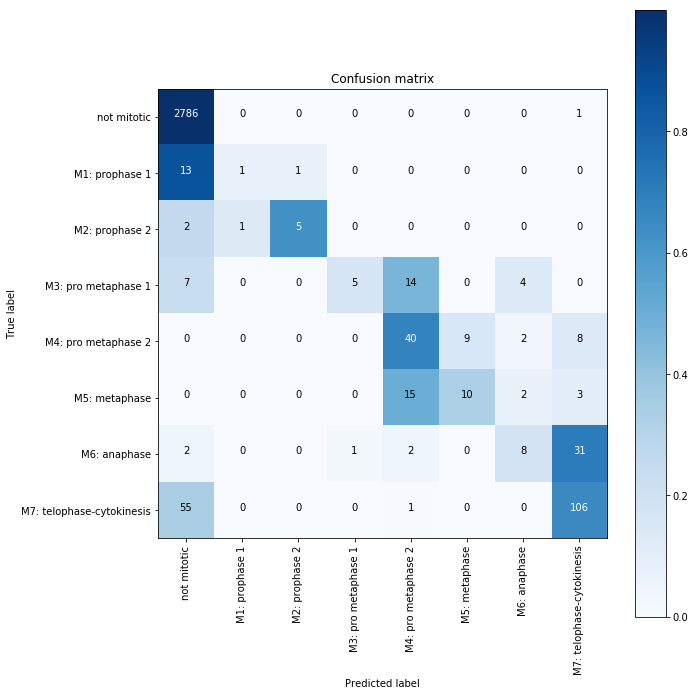

In [22]:
pred_classes_valid = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_validation)])
modelAnalysis(y_validation, pred_classes_valid)

## Predict on unannotated cells

### Load data

In [23]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Split into annotated and un-annotated data

In [24]:
target_col = 'MitosisLabel'
feature_cols = df.columns[df.columns.str.contains(pat = 'feat_cell|feat_nuc')]

df_known = df[~pd.isnull(df[target_col])]
df_unknown = df[pd.isnull(df[target_col])]
print(df_known.shape)
print(df_unknown.shape)

df_known = df_known.fillna(0)
df_unknown = df_unknown.fillna(0)

(7592, 2531)
(14376, 2531)


### Train models on all annotated data

In [25]:
X_train_test, y_train_test = make_X_y_from_df(df_known,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)

unique_classes, class_counts = np.unique(y_train_test, return_counts=True)
class_weights = class_counts/np.sum(class_counts)
class_weights

array([ 0.92123288,  0.00605901,  0.00395153,  0.00605901,  0.01290832,
        0.00698103,  0.00935195,  0.03345627])

### train K models using cross-validation splits

In [26]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(unique_classes),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 100
}

K=5
kf = StratifiedKFold(n_splits=K,shuffle=True)
cv_model_dict = {}

for k, (train_inds, test_inds) in enumerate(kf.split(X_train_test,y_train_test)):

    print("Cross-validation round {}:".format(k))
    
    X_train = X_train_test[train_inds]
    y_train = y_train_test[train_inds]
    X_test = X_train_test[test_inds]
    y_test = y_train_test[test_inds]
    
    lgb_train = lgb.Dataset(X_train, y_train,
                        weight=np.array([class_weights[int(i)] for i in y_train]),
                        free_raw_data=False)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                           weight=np.array([class_weights[int(i)] for i in y_test]),
                           free_raw_data=False)
    
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_test,
                    num_boost_round=1000,
                    verbose_eval=100,
                    early_stopping_rounds=5)
    
    cv_model_dict[k] = gbm
    print("")

Cross-validation round 0:
Training until validation scores don't improve for 5 rounds.
[100]	valid_0's multi_logloss: 0.575607
[200]	valid_0's multi_logloss: 0.206453
[300]	valid_0's multi_logloss: 0.0785163
[400]	valid_0's multi_logloss: 0.0319024
[500]	valid_0's multi_logloss: 0.0145549
[600]	valid_0's multi_logloss: 0.00794874
[700]	valid_0's multi_logloss: 0.0052304
[800]	valid_0's multi_logloss: 0.00424229
[900]	valid_0's multi_logloss: 0.00379794
Early stopping, best iteration is:
[930]	valid_0's multi_logloss: 0.00371865

Cross-validation round 1:
Training until validation scores don't improve for 5 rounds.
[100]	valid_0's multi_logloss: 0.575979
[200]	valid_0's multi_logloss: 0.208254
[300]	valid_0's multi_logloss: 0.0812634
[400]	valid_0's multi_logloss: 0.035488
[500]	valid_0's multi_logloss: 0.0186722
[600]	valid_0's multi_logloss: 0.0122587
[700]	valid_0's multi_logloss: 0.0103896
Early stopping, best iteration is:
[735]	valid_0's multi_logloss: 0.0101778

Cross-validation 

### Evaluate CV models

                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      1.00     27976
           M1: prophase 1       0.87      0.47      0.61       184
           M2: prophase 2       0.98      0.73      0.84       120
      M3: pro metaphase 1       0.93      0.88      0.91       184
      M4: pro metaphase 2       0.91      0.95      0.93       392
            M5: metaphase       0.95      0.85      0.90       212
             M6: anaphase       0.98      0.89      0.93       284
M7: telophase-cytokinesis       0.95      0.95      0.95      1016

              avg / total       0.99      0.99      0.99     30368

accuracy 0.990417544784


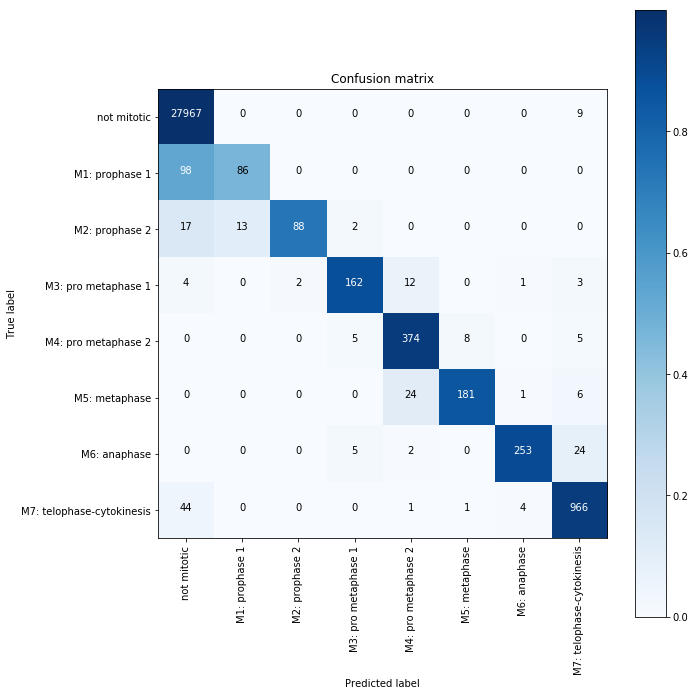

In [27]:
true_classes_train = []
pred_classes_train = []
for k, (train_inds, test_inds) in enumerate(kf.split(X_train_test,y_train_test)):
    
    X_train = X_train_test[train_inds]
    y_train = y_train_test[train_inds]
    X_test = X_train_test[test_inds]
    y_test = y_train_test[test_inds]
    
    true_classes_train += list(y_train)
    
    gbm_k = cv_model_dict[k]
    pred_classes_train += [np.argmax(pred_vec) for pred_vec in gbm_k.predict(X_train)]

modelAnalysis(true_classes_train, pred_classes_train)

### Perform predictions using majority vote

In [28]:
X_all = df[feature_cols]
X_all = X_all.fillna(0).values
X_all.shape

(21968, 1663)

In [29]:
ensemble_preds = np.zeros([X_all.shape[0],len(cv_model_dict.keys())])
ensemble_preds.shape
for k in cv_model_dict.keys():
    gbm_k = cv_model_dict[k]
    ensemble_preds[:,k] = np.array([np.argmax(pred_vec) for pred_vec in gbm_k.predict(X_all)])

In [30]:
np.unique(ensemble_preds, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 array([102886,    167,    241,    554,   1484,    413,    421,   3674]))

In [31]:
maj_vote,counts = mode(ensemble_preds, axis=1)
np.unique(maj_vote, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 array([20570,    32,    50,   120,   298,    77,    90,   731]))

### Merge in predictions

In [32]:
# pick out some minimally useful columns to save
df_key_and_ims = df[['inputFolder',
                     'inputFilename',
                     'outputThisCellIndex',
                     'save_flat_proj_reg_path',
                     'MitosisLabel']]

# add in predicted mitotic class
df_key_and_ims['MitosisLabelPredicted'] = pd.Series(maj_vote.squeeze(), index=df.index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Visually inspect predictions

#### Some images aren't actrually there!  this needs to get fixed!

In [33]:
df_key_and_ims.shape

(21968, 6)

In [34]:
# find files with nonzero size

im_dir = '/home/jovyan/aics/modeling/gregj/results/ipp_17_10_31'

df_key_and_ims['png_file_size'] = pd.Series(np.zeros(len(df_key_and_ims)))
for index, row in tqdm_notebook(df_key_and_ims.iterrows(),
                                total=len(df_key_and_ims),
                                desc='scanning files'):

    # for each file listed
    full_file_path = os.path.join(im_dir, df_key_and_ims.loc[index, 'save_flat_proj_reg_path'])

    # record the file size if it exists else recors zero
    df_key_and_ims.loc[index, 'png_file_size'] = os.path.getsize(full_file_path) if \
                                                     os.path.isfile(full_file_path) else \
                                                     np.NaN

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


HBox(children=(IntProgress(value=0, description='scanning files', max=21968), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Compare all un-annotated predictions to predictions on un-annoted cells where we actually have the pngs

In [35]:
np.unique(df_key_and_ims['MitosisLabelPredicted'], return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 array([20570,    32,    50,   120,   298,    77,    90,   731]))

In [36]:
df_key_and_ims_present = df_key_and_ims.dropna(subset=['png_file_size'])
np.unique(df_key_and_ims_present['MitosisLabelPredicted'], return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 array([16853,    25,    41,    96,   246,    66,    79,   500]))

### Inspect predictions visually on unannotated samples

In [37]:
df_key_and_ims_present_unannotated = df_key_and_ims_present[pd.isnull(df_key_and_ims_present[target_col])]
df_key_and_ims_present_unannotated.shape

(11797, 7)

phase 0.0:


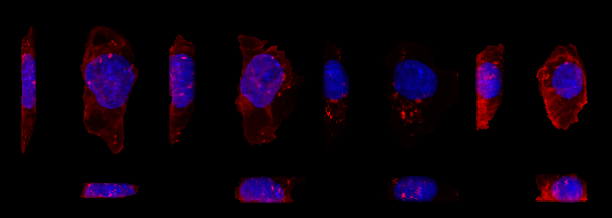

phase 1.0:


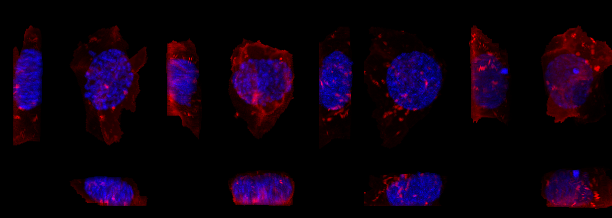

phase 2.0:


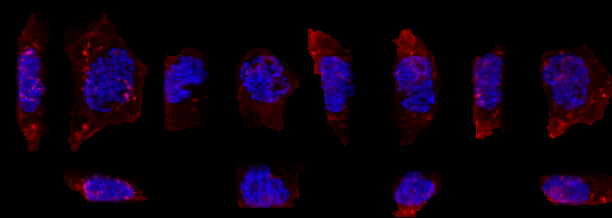

phase 3.0:


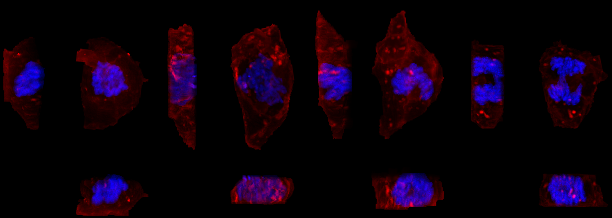

phase 4.0:


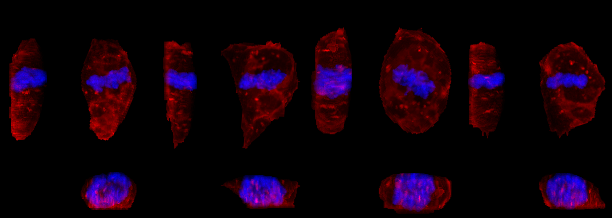

phase 5.0:


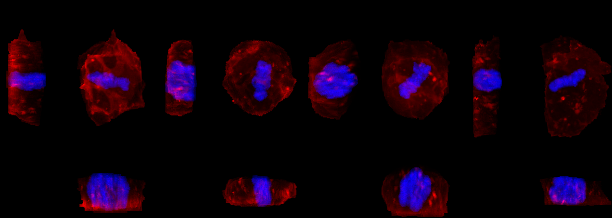

phase 6.0:


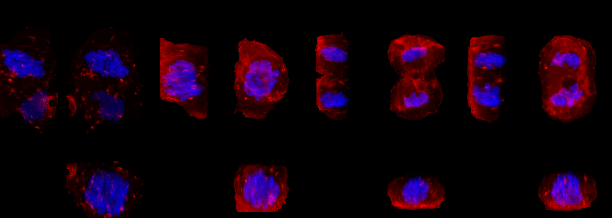

phase 7.0:


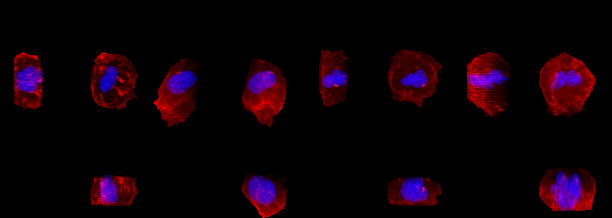

In [38]:
im_dir = '/home/jovyan/aics/modeling/gregj/results/ipp_17_10_31'
img_dims = (218,153,3)
N_samples = 4
image_stacks = {}

for c in np.unique(df_key_and_ims_present_unannotated['MitosisLabelPredicted']):
    query_string = 'MitosisLabelPredicted == {}'.format(c)
    pred_c_samples = df_key_and_ims_present_unannotated.query(query_string)["save_flat_proj_reg_path"].sample(N_samples).values
    
    image_stack = np.zeros(shape=(img_dims[0],0,img_dims[2]), dtype=np.uint8)
    for i,img_loc in enumerate(pred_c_samples):
        img_path = os.path.join(im_dir,img_loc)
        this_img = np.array(Image.open(img_path))
        this_img[:,:,1] = 0  # remove structure channel
        this_img = this_img[:img_dims[0],:img_dims[1],:img_dims[2]]
        image_stack = np.hstack([image_stack, this_img])
    image_stacks[c] = image_stack
    
for k,v in image_stacks.items():
    image = Image.fromarray(v)
    print('phase {}:'.format(k))
    display(image)

#### Save prediction csv

In [39]:
df_key_and_ims.to_csv('mitotic_predictions_gbdts.csv', index=False)